# Clustering Analysis
The purpose of our cluster analysis is to:
- Measure clustering & central tendency.
- Perform k-means
- Evaluate the clusters, **particularly**:
    - unhealthy vs healthy
    - study vs study

In [202]:
from pyclustertend import ivat, vat
from sklearn.preprocessing import scale
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
from pyclustertend import ivat
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns


## Measure Cluster Tendency
Clustering algorithms such as k-means are used to determine the structure of multi-dimensional data. Clusters are natural disjoint groups. However, K-means will find clusters in data even if none "actually" exist. Therefore, a fundamentally question to ask before applying any clustering algorithms is : Are clusters present at all?
We will measure the clustering tendency of both datasets before subjecting it to k-means. These datasets contain the top **two principal components (2D)** and the top **three principal components (3D)**, respectively To do this, we employ two methods:
- Hopkins's statistic  of randomness
- VAT (visual assessment of tendency)

### Hopkins statistics
Hopkins statistics {cite:p}`banerjee2004validating` tests the spatial randomness of a dataset i.e. it measures the probability that a given dataset is generated by a uniform distribution. It is based on the difference between the distance from a real point to its nearest neighbor, U, and the distance from a uniformly generated point within the data space to the nearest real data point, W.

- $H_{0}$: The dataset **is** uniformly distributed 
- $H_{1}$: The dataset **is not** uniformly distributed 

$$
H = \frac{\sum_{i=1}^{m} u_{i}^{d}}{\sum_{i=1}^{m} u_{i}^{d} + \sum_{i=1}^{m} w_{i}^{d}}
$$

If the value of the hopkins statistic(H) is close to 1 (above 0.5), we reject $H_{0}$ and can conclude that the dataset is considered significantly clusterable.  Otherwise, we fail to reject $H_{0}$ and can conclude that the dataset is considered significantly uniformly distributed.

In [203]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [204]:
dim_reduced_2d = pd.read_csv('data/dim_reduced_2d.tsv', sep="\t")
dim_reduced_3d = pd.read_csv('data/dim_reduced_3d.tsv', sep="\t")


For both datasets, we reject $H_{0}$ and can conclude that both datasets have a significant tendency to cluster.

In [205]:
print(f"Choice's hopkins statistic {hopkins(dim_reduced_choice.iloc[:,2:])}")
print(f"Reward's hopkins statistic {hopkins(dim_reduced_rewards.iloc[:,2:])}") 

Choice's hopkins statistic 0.7930137356918954
Reward's hopkins statistic 0.8001237927656264


#### IVAT (visual assessment of tendency)
VAT is visual method of assessing the clustering likelihood of a dataset. VAT creates a minimum spanning tree of observations, where the pairwise distance between those observations is displayed as the black squares of an ordered dissimilarity square-shaped Map. The densely black squares on the diagonal can be understood as the number of clusters. The different shade of black provides insight on not only the numbers of clusters but, also the cluster hierarchy. **Note**, This algorithm is not a substitute for cluster evaluation metrics (Elbow, Silhouette coefficient). It merely suggests if clusters exist in the datasets, so as to avoid conducting cluster analysis on datasets in the first place. IVAT is just an improved version improved version of the VAT algorithm which produce more precise images but is more computational expensive.


**IVAT MAP 2D**

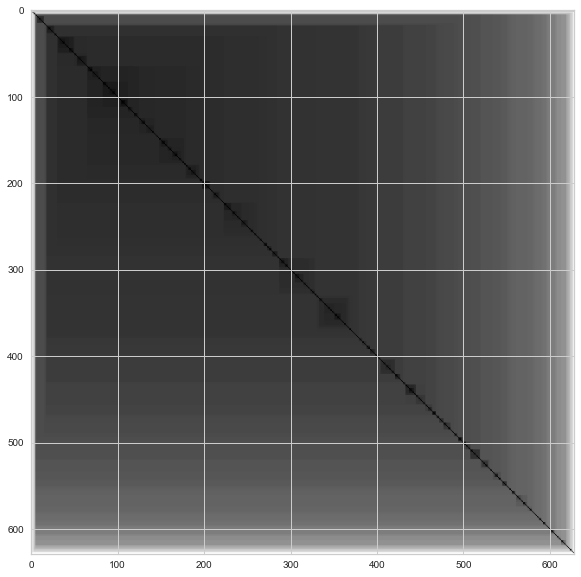

In [206]:
ivat(dim_reduced_2d.iloc[:,2:].values)



**IVAT MAP 3D**


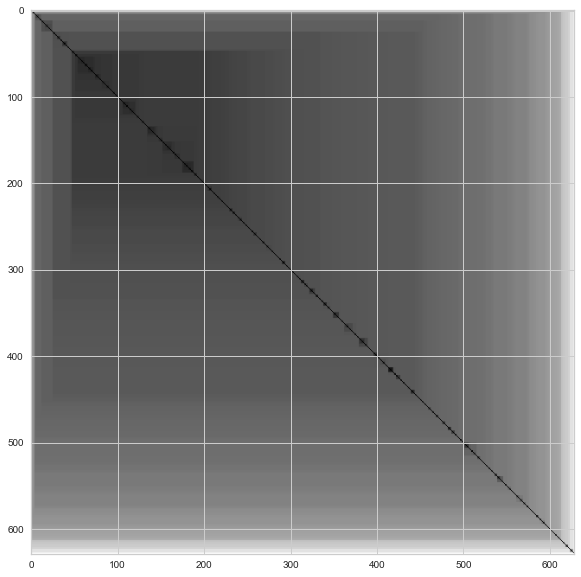

In [207]:
ivat(dim_reduced_3d.iloc[:,2:].values)

From the result of implementing IVAT, it is observed from the maps produced are inconclusive for both datasets. However, as this algorithm is just meant to help us decide if we should go ahead with the cluster analysis or not, we will go ahead with the K-means cluster analysis as both hopkins stastic results were significant.

## K-Means

K-means is a common clustering algorithm. Although a simple clustering algorithm , it has wide application areas including in customer segmentation and Image compression. K-means is a centroid based algorithm that aims to minimize the sum of distances between the points and their respective cluster centroid..  The main steps of this algorithm are:

- **Step 1**: Choose the number (k) of clusters
- **Step 2**: Select k random points which will become the inital centroids
- **Step 3**: Assign all data points to the nearest centroid.
- **step 4**: Compute the centroid of the newly formed clusters by by taking the
mean of data instances currently associated with that cluster.
- **Step 5**: Repeat steps 3 and 4 untill either:
    - Centroids of newly formed clusters do not change
    - Points remain in the same cluster
    - Maximum number of iterations are reached

But how do we find the optimal number of clusters?
- Elbow method
- Silhouette coefficient

### Elbow method
The Elbow method calculates the error or 'distortion' between the data points ($y_{i}$) and their corresponding centroid ($ŷ_{i}$) of N data points for k clusters where k ⋹ {1...10}. The error metric used is the Sum of Squared Error (SSE):
$$
SSE = \sum_{i=1}^{N} {(y_i - ŷ_i)^2}
$$

We plot these values in an attempt to find an 'elbow' within the curve.

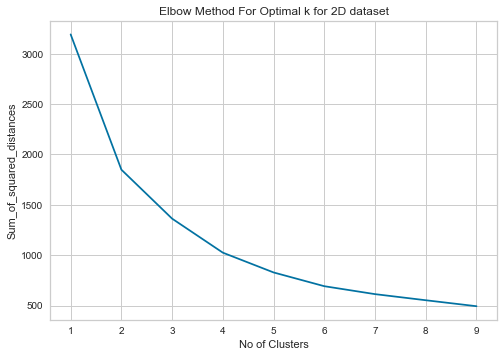

In [211]:
Sum_of_squared_distances = []
for k in range(1, 10):
    km_2d = KMeans(n_clusters=k, random_state=42)
    km_2d = km_2d.fit(dim_reduced_2d.iloc[:, 2:])
    Sum_of_squared_distances.append(km_2d.inertia_)
plt.plot(range(1, 10), Sum_of_squared_distances, 'bx-')
plt.xlabel('No of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for 2D dataset')
plt.show()

We can see that the optimal number of clusters occur at k=2 to 4.

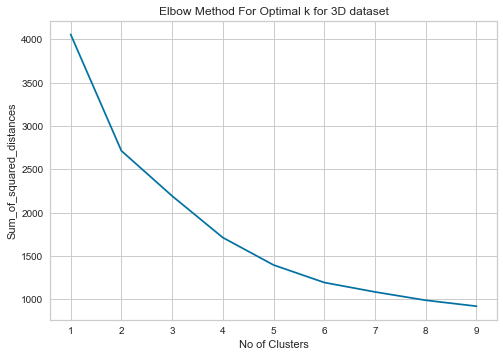

In [213]:
Sum_of_squared_distances = []
for k in range(1, 10):
    km_3d = KMeans(n_clusters=k, random_state=42)
    km_3d = km_3d.fit(dim_reduced_3d.iloc[:, 2:])
    Sum_of_squared_distances.append(km_3d.inertia_)
plt.plot(range(1, 10), Sum_of_squared_distances, 'bx-')
plt.xlabel('No of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for 3D dataset')
plt.show()


Here, determining the amount of clusters is more ambiguous. But I believe there is a dip at k=2 to k=6 mark.

## Sillhoute method

This method is another method of finding the correct number of clusters(k). Silhouette coefficient for a particular data point ($i$), is defined as:
$$
s_{i} = \frac{b_{i} - a_{i}}{max(b_{i}, a_{i})}
$$
where:
- $s_{i}$: the silhouette coefficient, ranging from -1 to 1. A score of 1 (the best) means that data point $i$ is compact in its cluster and far away from other clusters. Conversely, the worst value is -1, while values near 0 denote overlapping clusters.
- $b_{i}$: average distance between $i$ and all the other data points in its cluster. 
- $a_{i}$: minimum average distance from $i$ to all clusters to which $i$ does not belong to

We evaluate using silhouette plots. These plots display how close each point in one cluster is to points in the neighboring clusters.

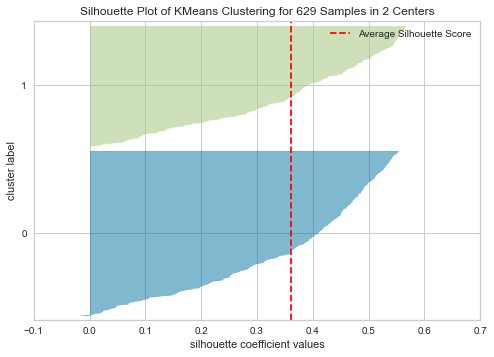

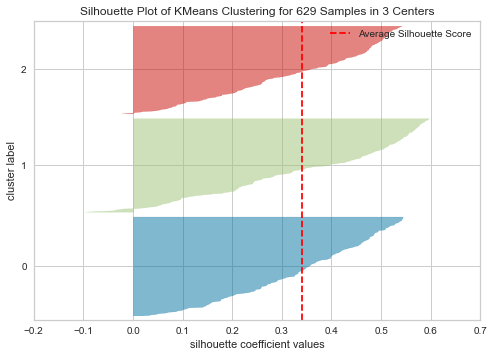

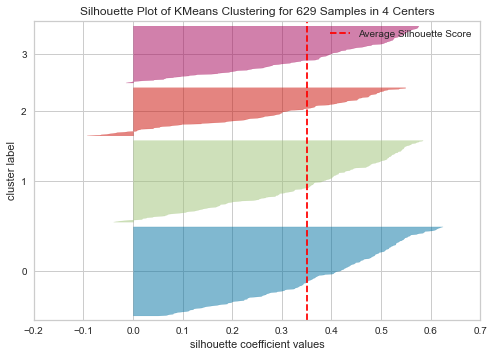

In [214]:
from yellowbrick.cluster import SilhouetteVisualizer
for k in  range(2,5):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(dim_reduced_2d.iloc[:, 2:])
    visualizer.show()

This lies up with our previous assumption on the optimal number of clusters of the 2d dataset is 3. K=4 seem to be sub optimal due to wide foundations in size of the silhouette plot. The silhouette score for each cluster is above average silhouette scores when k =2, 3 or 4. However the fluctuation in size at 3 seems to be more uniform compared to 2. Thus, we  select the optimal number of clusters as 3.  

Another method of evaluating is to simply plot the silhouette coefficient

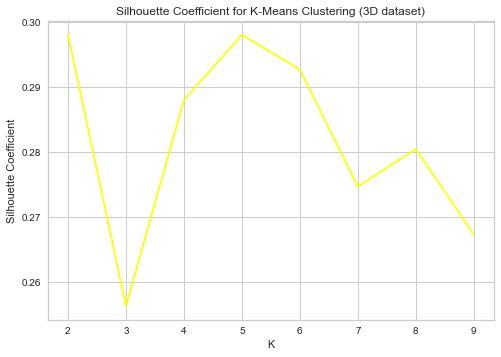

In [215]:
sill_coef = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(dim_reduced_3d.iloc[:,2:])
    sill_coef.append(silhouette_score(dim_reduced_3d.iloc[:,2:], kmeanModel.labels_))

plt.plot(K, sill_coef,  color='yellow')
plt.xlabel('K')
plt.title('Silhouette Coefficient for K-Means Clustering (3D dataset)')
plt.ylabel("Silhouette Coefficient")
plt.show()


Here, we find the optimal number of cluster to be k=2 and 5 as these values of k maximizes the silhouette coefficient.

## Findings

As mentioned previously, clusters can be considered as disjoint groups. In this context, these clusters seek to represent people with similar latent physiological process or possible decision strategies. K-means clusters individuals by their choice options, a health binary variable variable if they are healthy or not and the cumulative reward at various intervals in the task in an attempt to relate the groupings to the the decision-making behavior of individual participants.

### Top 2 principal component dataset



In [228]:
km_2d = KMeans(n_clusters=3, random_state=42).fit(dim_reduced_3d.iloc[:, 2:])
dim_reduced_2d["clusters"] = km_2d.labels_ + 1
dim_reduced_2d['health binary'] = dim_reduced_2d['health status'].apply(lambda x:  1 if x =='healthy' else 0)

<AxesSubplot:xlabel='component_1', ylabel='component_2'>

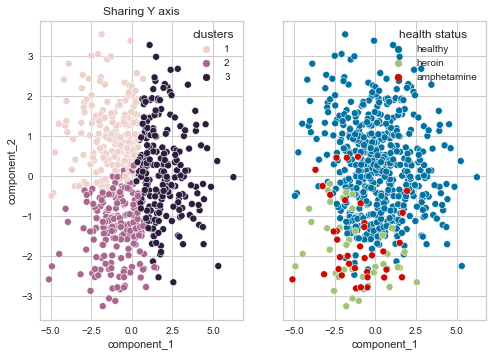

In [237]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# ax1.plot(df.x, df.y)
ax1.set_title('Sharing Y axis')
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='clusters', ax=ax1)
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='health status', ax=ax2)

In [226]:
ax = sns.heatmap(dim_reduced_2d[['health status', "cluster labels k="]], cmap="YlGnBu")

ValueError: could not convert string to float: 'healthy'

In [173]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)
ax = sns.heatmap(dim_reduced_2d[['health status', "cluster labels k=2"]], cmap="YlGnBu"

URLError: <urlopen error unknown url type: https>

In [ ]:

fig, ax = plt.subplots()
sn.heatmap(cm, ax=ax, annot=cm)

ax.set_xlabel("Cluster")
ax.set_ylabel("Helth Staus")
ax.set_yticklabels(df_orl["subjID"].astype("category").cat.categories)
plt.show()




#### Healthy vs Unhealthy


#### Study vs Study



### Top 3 principal compnent  dataset

#### Healthy vs Unhealthy

#### Study vs Study



#### (k=2, 2D dataset) 

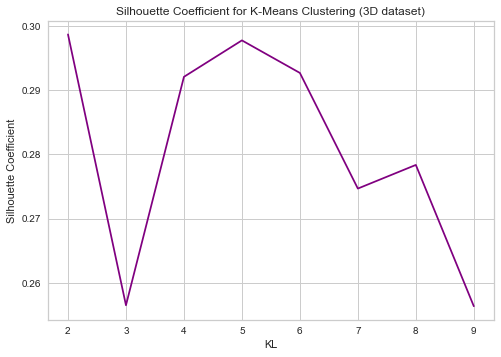

In [155]:
kmeans2 = KMeans(n_clusters=2).fit(df_orl[["BetaF", "BetaP"]])
cm = confusion_matrix(df_orl["subjID_label"].values, kmeans2.labels_)
